In [8]:
import os
os.chdir("C:/Users/ysf/Desktop/stage_PFE/face_dataset/new_face")

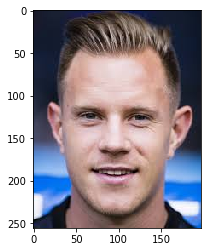

found faces:  1
found eyes:  2
[49 50]
rotate to inverse clock direction
angle:  1.005086005254142  in degree
angle:  1.005086005254142  in degree


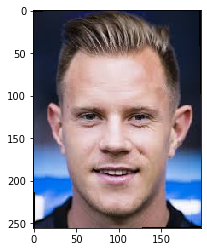

found faces:  1


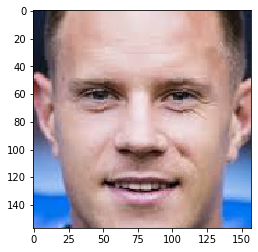

In [51]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from PIL import Image

#------------------------

def euclidean_distance(a, b):
	x1 = a[0]; y1 = a[1]
	x2 = b[0]; y2 = b[1]
	
	return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

def detectFace(img):
	faces = face_detector.detectMultiScale(img, 1.3, 5)
	print("found faces: ", len(faces))

	if len(faces) > 0:
		face = faces[0]
		face_x, face_y, face_w, face_h = face
		img = img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
		img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		
		return img, img_gray
	else:
		img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		return img, img_gray

def alignFace(img_path):
	img = cv2.imread(img_path)
	plt.imshow(img[:, :, ::-1])
	plt.show()

	img_raw = img.copy()

	img, gray_img = detectFace(img)
	
	eyes = eye_detector.detectMultiScale(gray_img)
	
	print("found eyes: ",len(eyes))
	
	if len(eyes) >= 2:
		base_eyes = eyes[:, 2]
		print(base_eyes)
		
		items = []
		for i in range(0, len(base_eyes)):
			item = (base_eyes[i], i)
			items.append(item)
		
		df = pd.DataFrame(items, columns = ["length", "idx"]).sort_values(by=['length'], ascending=False)
		
		eyes = eyes[df.idx.values[0:2]]
		
		#--------------------
		#decide left and right eye
		
		eye_1 = eyes[0]; eye_2 = eyes[1]
		
		if eye_1[0] < eye_2[0]:
			left_eye = eye_1
			right_eye = eye_2
		else:
			left_eye = eye_2
			right_eye = eye_1
		
		#--------------------
		#center of eyes
		
		left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
		left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
		
		right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
		right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
		
		#center_of_eyes = (int((left_eye_x+right_eye_x)/2), int((left_eye_y+right_eye_y)/2))
		
		cv2.circle(img, left_eye_center, 2, (255, 0, 0) , 2)
		cv2.circle(img, right_eye_center, 2, (255, 0, 0) , 2)
		#cv2.circle(img, center_of_eyes, 2, (255, 0, 0) , 2)
		
		#----------------------
		#find rotation direction
		
		if left_eye_y > right_eye_y:
			point_3rd = (right_eye_x, left_eye_y)
			direction = -1 #rotate same direction to clock
			print("rotate to clock direction")
		else:
			point_3rd = (left_eye_x, right_eye_y)
			direction = 1 #rotate inverse direction of clock
			print("rotate to inverse clock direction")
		
		#----------------------
		
		cv2.circle(img, point_3rd, 2, (255, 0, 0) , 2)
		
		cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
		cv2.line(img,left_eye_center, point_3rd,(67,67,67),1)
		cv2.line(img,right_eye_center, point_3rd,(67,67,67),1)
		
		a = euclidean_distance(left_eye_center, point_3rd)
		b = euclidean_distance(right_eye_center, point_3rd)
		c = euclidean_distance(right_eye_center, left_eye_center)
		
		cos_a = (b*b + c*c - a*a)/(2*b*c)
		#print("cos(a) = ", cos_a)
		angle = np.arccos(cos_a)
		#print("angle: ", angle," in radian")
		
		angle = (angle * 180) / math.pi
		print("angle: ", angle," in degree")
		
		if direction == -1:
			angle = 90 - angle
		
		print("angle: ", angle," in degree")
		
		#--------------------
		#rotate image
		
		new_img = Image.fromarray(img_raw)
		new_img = np.array(new_img.rotate(direction * angle))
	
	return new_img
	
#------------------------

#opencv path

opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]

path = folders[0]
for folder in folders[1:]:
	path = path + "/" + folder

face_detector_path = path+"/data/haarcascade_frontalface_default.xml"
eye_detector_path = path+"/data/haarcascade_eye.xml"
nose_detector_path = path+"/data/haarcascade_mcs_nose.xml"

if os.path.isfile(face_detector_path) != True:
	raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")

face_detector = cv2.CascadeClassifier(face_detector_path)
eye_detector = cv2.CascadeClassifier(eye_detector_path) 
nose_detector = cv2.CascadeClassifier(nose_detector_path) 

#------------------------

#test_set = ["angelina.jpg", "angelina2.jpg", "angelina3.jpg"]
test_set = ["images.jpg"]

for instance in test_set:
	alignedFace = alignFace(instance)
	plt.imshow(alignedFace[:, :, ::-1])
	plt.show()
	
	img, gray_img = detectFace(alignedFace)
	plt.imshow(img[:, :, ::-1])
	plt.show()